In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import math
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay
from tqdm import tqdm
pd.set_option("display.max_columns", None)

PATH = "C:/Users/jackl/OneDrive/Documents/finance_research/japan_qe/"

def get_plot_data(bottom_quintile_end, mean=True, yr=True):
    if yr == True: 
        if mean:
            return bottom_quintile_end.groupby('event_day')['ab_turnover_yr'].mean()
        else:
            return bottom_quintile_end.groupby('event_day')['ab_turnover_yr'].median()
    else: 
        if mean:
            return bottom_quintile_end.groupby('event_day')['ab_turnover_qtr'].mean()
        else:
            return bottom_quintile_end.groupby('event_day')['ab_turnover_qtr'].median()  
    
def get_boj_quintiles_conditional(sue_df_boj_merged, suffix=None, quantiles=5):
    sue_df_boj_merged_nd = sue_df_boj_merged[['SEDOL', 'qtr_yr_index', 'boj_share_shares']].drop_duplicates()
    sue_df_boj_merged_nd_list = []
    for index, df in tqdm(sue_df_boj_merged_nd.groupby('qtr_yr_index')): 
        try:
            df['boj_share_shares_quantiles_'+suffix] = pd.qcut(df['boj_share_shares'], quantiles, labels=False)
        except: 
            df['boj_share_shares_quantiles_'+suffix] = [math.nan for i in range(len(df))]

        sue_df_boj_merged_nd_list.append(df)

    sue_df_boj_merged_nd = pd.concat(sue_df_boj_merged_nd_list)

    sue_df_boj_merged = pd.merge(sue_df_boj_merged, 
                                 sue_df_boj_merged_nd, 
                                 on=['SEDOL', 'qtr_yr_index', 'boj_share_shares'])
    return sue_df_boj_merged

def get_firm_quarter_count(df):
    return df.drop_duplicates(['SEDOL', 'eff_anndats'])

In [32]:
def get_truncated_df(merge_df, columns, year_column_name=None, low=0.01, high=0.99):
    merge_df_copy = merge_df.copy()
    if year_column_name == None:
        for column in columns: 
            _1pct, _99pct = merge_df_copy[column].quantile(q=low), merge_df_copy[column].quantile(q=high)
            merge_df_copy[column].where((merge_df_copy[column] < _99pct) & (merge_df_copy[column] > _1pct), math.nan, inplace=True)
    else: 
        merge_df_list = []
        merge_year_df_list = [[year, merge_year_df] for year, merge_year_df in merge_df_copy.groupby(year_column_name)]
        for year, merge_year_df in tqdm(merge_year_df_list):
            for column in columns: 
                _1pct, _99pct = merge_year_df[column].quantile(q=low), merge_year_df[column].quantile(q=high)
                merge_year_df[column].where(~((merge_year_df[column] > _99pct) | (merge_year_df[column] < _1pct)), math.nan, inplace=True)
            merge_df_list.append(merge_year_df)
        merge_df_copy = pd.concat(merge_df_list)
    
    return merge_df_copy

In [78]:
vol_df = pd.read_pickle(PATH+'checkpoint_data/volume_sue_df.pkl')

In [79]:
nk_vol_df = vol_df[vol_df['nk_flag']==1]
nk_vol_df = get_boj_quintiles_conditional(nk_vol_df, suffix='nk', quantiles=10)
nk_vol_df = get_truncated_df(nk_vol_df, 
                             columns=['ab_turnover_yr', 'ab_turnover_qtr'], 
                             year_column_name=None, 
                             low=0.01, 
                             high=0.99)

100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 292.83it/s]


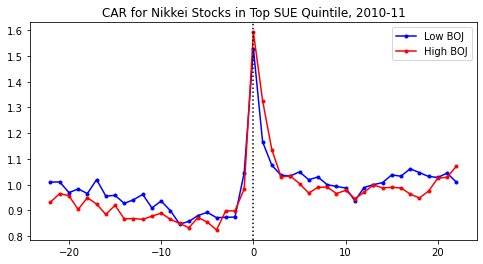

In [80]:
date1, date2 = pd.to_datetime('2010-12-01'), pd.to_datetime('2011-10-31')
vol_subset_df = nk_vol_df[(nk_vol_df['eff_anndats'] >= date1) & (nk_vol_df['eff_anndats'] <= date2)]
vol_subset_df_low_boj = vol_subset_df[vol_subset_df['boj_share_shares_quantiles_nk'].isin([0, 1, 2, 3, 4])]
vol_subset_df_high_boj = vol_subset_df[vol_subset_df['boj_share_shares_quantiles_nk'].isin([9, 8, 7, 6, 5])]

plt.figure(figsize=(8,4))
plt.plot(get_plot_data(vol_subset_df_low_boj, mean=True), label='Low BOJ', color='b', marker='.')
plt.plot(get_plot_data(vol_subset_df_high_boj, mean=True), label='High BOJ', color='r', marker='.')
plt.axvline(x=0, color='k', ls=':')

plt.title('CAR for Nikkei Stocks in Top SUE Quintile, 2010-11')
# plt.xlabel('Trading Day')
# plt.ylabel('CAR')
plt.legend()

# # plt.savefig('images/top_sue_decile_car')
plt.show()

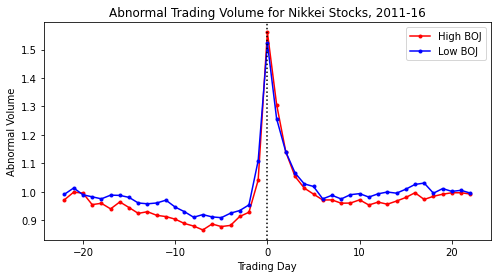

In [85]:
date1, date2 = pd.to_datetime('2010-12-01'), pd.to_datetime('2015-12-31')
vol_subset_df = nk_vol_df[(nk_vol_df['eff_anndats'] >= date1) & (nk_vol_df['eff_anndats'] <= date2)]
vol_subset_df_low_boj = vol_subset_df[vol_subset_df['boj_share_shares_quantiles_nk'].isin([0, 1, 2, 3, 4])]
vol_subset_df_high_boj = vol_subset_df[vol_subset_df['boj_share_shares_quantiles_nk'].isin([9, 8, 7, 6, 5])]

plt.figure(figsize=(8,4))
plt.plot(get_plot_data(vol_subset_df_high_boj, mean=True), label='High BOJ', color='r', marker='.')
plt.plot(get_plot_data(vol_subset_df_low_boj, mean=True), label='Low BOJ', color='b', marker='.')
plt.axvline(x=0, color='k', ls=':')

plt.title('Abnormal Trading Volume for Nikkei Stocks, 2011-16')
plt.xlabel('Trading Day')
plt.ylabel('Abnormal Volume')
plt.legend()

plt.savefig(PATH+'images/oct20/volume_1')
plt.show()

In [86]:
weight_df = pd.read_pickle(PATH+'checkpoint_data/index_weights.pkl')
nk_weights_2010 = weight_df[(weight_df['indexlistmnem']=='LJAPDOWA') & (weight_df['month']==12) & (weight_df['yr']==2010)]
nk_weights_2010['2010_nk_weight_decile'] = pd.qcut(nk_weights_2010['weight'], 10, labels=False)
nk_weights_2010 = nk_weights_2010[['sedol', '2010_nk_weight_decile', 'weight']]
nk_weights_2010.columns = ['sedol', '2010_nk_weight_decile', 'nk_weight']

<ipython-input-86-55b74d0c022a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nk_weights_2010['2010_nk_weight_decile'] = pd.qcut(nk_weights_2010['weight'], 10, labels=False)


In [87]:
nk_vol_df = vol_df[vol_df['nk_flag']==1]
nk_vol_df = get_boj_quintiles_conditional(nk_vol_df, suffix='nk', quantiles=10)
nk_vol_df_w_2010_weights = pd.merge(nk_vol_df, 
                                    nk_weights_2010, 
                                    left_on=['SEDOL'], 
                                    right_on=['sedol'], 
                                    how='left').drop(columns='sedol')

nk_vol_df_w_2010_weights = get_truncated_df(nk_vol_df_w_2010_weights, 
                                            columns=['ab_turnover_yr', 'ab_turnover_qtr'], 
                                            year_column_name=None, 
                                            low=0.01, 
                                            high=0.99)

100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 234.23it/s]


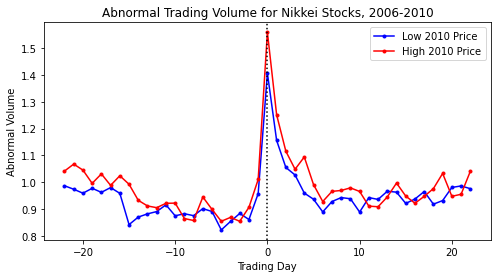

In [95]:
date1, date2 = pd.to_datetime('2006-12-01'), pd.to_datetime('2010-12-10')
nk_subset_df = nk_vol_df_w_2010_weights[(nk_vol_df_w_2010_weights['eff_anndats'] >= date1) &
                                        (nk_vol_df_w_2010_weights['eff_anndats'] <= date2)]
nk_subset_low_price_df = nk_subset_df[nk_subset_df['2010_nk_weight_decile'].isin([0, 1, 2, 3, 4])]
nk_subset_high_price_df = nk_subset_df[nk_subset_df['2010_nk_weight_decile'].isin([9, 8, 7, 6, 5])]

plt.figure(figsize=(8,4))
plt.plot(get_plot_data(nk_subset_low_price_df, mean=True, yr=True), label='Low 2010 Price', color='b', marker='.')
plt.plot(get_plot_data(nk_subset_high_price_df, mean=True, yr=True), label='High 2010 Price', color='r', marker='.')
plt.axvline(x=0, color='k', ls=':')

plt.title('Abnormal Trading Volume for Nikkei Stocks, 2006-2010')
plt.xlabel('Trading Day')
plt.ylabel('Abnormal Volume')
plt.legend()

plt.savefig(PATH+'images/oct20/volume_2')
plt.show()

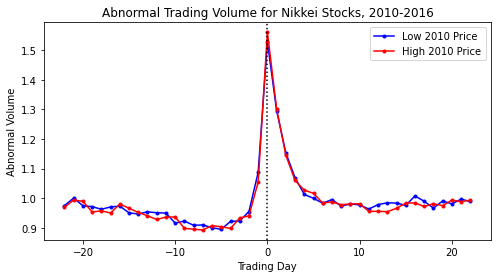

In [94]:
date1, date2 = pd.to_datetime('2010-12-10'), pd.to_datetime('2016-12-10')
nk_subset_df = nk_vol_df_w_2010_weights[(nk_vol_df_w_2010_weights['eff_anndats'] >= date1) &
                                        (nk_vol_df_w_2010_weights['eff_anndats'] <= date2)]
nk_subset_low_price_df = nk_subset_df[nk_subset_df['2010_nk_weight_decile'].isin([0, 1, 2, 3, 4])]
nk_subset_high_price_df = nk_subset_df[nk_subset_df['2010_nk_weight_decile'].isin([9, 8, 7, 6, 5])]

plt.figure(figsize=(8,4))
plt.plot(get_plot_data(nk_subset_low_price_df, mean=True, yr=True), label='Low 2010 Price', color='b', marker='.')
plt.plot(get_plot_data(nk_subset_high_price_df, mean=True, yr=True), label='High 2010 Price', color='r', marker='.')
plt.axvline(x=0, color='k', ls=':')

plt.title('Abnormal Trading Volume for Nikkei Stocks, 2010-2016')
plt.xlabel('Trading Day')
plt.ylabel('Abnormal Volume')
plt.legend()

plt.savefig(PATH+'images/oct20/volume_3')
plt.show()

In [97]:
def get_turnover_price_cond_graph(date1, date2):
    nk_subset_df = nk_vol_df_w_2010_weights[(nk_vol_df_w_2010_weights['eff_anndats'] >= date1) & 
                                            (nk_vol_df_w_2010_weights['eff_anndats'] <= date2)]
    nk_subset_low_price_df = nk_subset_df[nk_subset_df['2010_nk_weight_decile'].isin([0, 1, 2, 3, 4])]
    nk_subset_high_price_df = nk_subset_df[nk_subset_df['2010_nk_weight_decile'].isin([9, 8, 7, 6, 5])]
    plt.figure(figsize=(6,3))
    plt.plot(get_plot_data(nk_subset_low_price_df, mean=True, yr=False), label='Low Price', color='b', marker='.')
    plt.plot(get_plot_data(nk_subset_high_price_df, mean=True, yr=False), label='High Price', color='r', marker='.')
    plt.axvline(x=0, color='k', ls=':')
    plt.title('Abnormal Volume: ' + str(date1.year))
    plt.xlabel('Trading Day')
    plt.ylabel('Abnormal Volume')
    plt.legend()
    # plt.savefig(PATH+'images/top_sue_decile_car')
    plt.show()

get_turnover_price_cond_graph(date1=pd.to_datetime('01-01-2006'), date2=pd.to_datetime('01-01-2007'))
get_turnover_price_cond_graph(date1=pd.to_datetime('01-01-2007'), date2=pd.to_datetime('01-01-2008'))
get_turnover_price_cond_graph(date1=pd.to_datetime('01-01-2008'), date2=pd.to_datetime('01-01-2009'))
get_turnover_price_cond_graph(date1=pd.to_datetime('01-01-2009'), date2=pd.to_datetime('01-01-2010'))
get_turnover_price_cond_graph(date1=pd.to_datetime('01-01-2010'), date2=pd.to_datetime('01-01-2011'))
get_turnover_price_cond_graph(date1=pd.to_datetime('01-01-2011'), date2=pd.to_datetime('01-01-2012'))
get_turnover_price_cond_graph(date1=pd.to_datetime('01-01-2012'), date2=pd.to_datetime('01-01-2013'))
get_turnover_price_cond_graph(date1=pd.to_datetime('01-01-2013'), date2=pd.to_datetime('01-01-2014'))
get_turnover_price_cond_graph(date1=pd.to_datetime('01-01-2014'), date2=pd.to_datetime('01-01-2015'))
get_turnover_price_cond_graph(date1=pd.to_datetime('01-01-2015'), date2=pd.to_datetime('01-01-2016'))
get_turnover_price_cond_graph(date1=pd.to_datetime('01-01-2016'), date2=pd.to_datetime('01-01-2017'))